##t-SNE visualization on image features extracted from EfficientNet B0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import random
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import datasets, models
from tqdm import tqdm_notebook
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
seed = 1024
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [ ]:
!pip install efficientnet-pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-cp37-none-any.whl size=16443 sha256=d812ec75ae8fee9f8da226b0b5b3d2990d896a1a2a6f625ec50b7b5f68d42b76
  Stored in directory: /root/.cache/pip/wheels/84/27/aa/c46d23c4e8cc72d41283862b1437e0b3ad318417e8ed7d5921
Successfully built efficientnet-pytorch


In [ ]:
from efficientnet_pytorch import EfficientNet

###Load Data

In [ ]:
data_dir = '/content/drive/MyDrive/dlproject/data/output/'

train_dir = os.path.join(data_dir, 'train/')

classes = ['COVID-19', 'Normal', 'Pneumonia-Bacterial', 'Pneumonia-Viral']
image_size = (224, 224)
batch_size = 64
num_workers = 2

In [ ]:
normalize = transforms.Normalize(mean=[0.4907, 0.4907, 0.4908],
                                 std=[0.2219, 0.2219, 0.2219])

train_transforms = transforms.Compose([transforms.Resize(image_size),  
                                       transforms.ToTensor(),
                                       normalize])

train_datasets = datasets.ImageFolder(train_dir, train_transforms)

train_loaders = DataLoader(train_datasets, 
                           shuffle=True, 
                           batch_size=batch_size, 
                           num_workers=num_workers)

###Extract Features for Visualization

In [ ]:
class EfficientNet_features(nn.Module):
    def __init__(self, model_name='efficientnet-b0'):
        super(EfficientNet_features, self).__init__()
        model = EfficientNet.from_pretrained(model_name)
        self.model = model

    def forward(self,x):
        x = self.model.extract_features(x)
        x = nn.functional.adaptive_avg_pool2d(x, 1).squeeze(-1).squeeze(-1)
        return x

In [ ]:
model = EfficientNet_features()
model.eval()
model.cuda()

Loaded pretrained weights for efficientnet-b0


EfficientNet_features(
  (model): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
  

In [ ]:
features = None
labels = None

for data, target in train_loaders:
    data = data.cuda()
    target = target.cuda()

    with torch.no_grad():
        output = model(data)

    if features is not None:
        features = torch.cat((features, output), dim=0)
        labels = torch.cat((labels, target), dim=0)
    else:
        features = output
        labels = target

features = features.cpu().numpy()
labels = labels.cpu().numpy()

In [ ]:
print(features.shape)
print(labels.shape)

(5523, 1280)
(5523,)


In [ ]:
type_to_label = train_datasets.class_to_idx
label_to_type = {v: k for k, v in type_to_label.items()}
print(label_to_type)

{0: 'COVID-19', 1: 'Normal', 2: 'Pneumonia-Bacterial', 3: 'Pneumonia-Viral'}


###t-SNE Visualization

In [ ]:
tsne = TSNE(n_components=2, perplexity=30).fit_transform(features)

In [ ]:
# Normalize to 0-1 scale
normalized_tsne = (tsne - tsne.min(0)) / tsne.ptp(0)

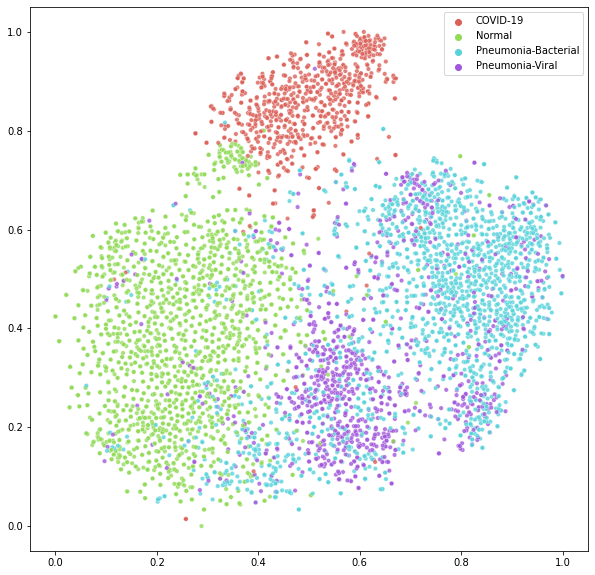

In [ ]:
plt.figure(figsize=(10, 10))
sns.scatterplot(
    x=normalized_tsne[:, 0], 
    y=normalized_tsne[:, 1], 
    hue=types,
    palette=sns.color_palette("hls", 4),
    legend="full",
    alpha=0.8, 
    s=20, 
    hue_order=classes
)

###PCA Visualization for Comparison

In [ ]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features)
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.1858433 0.0983723]


In [ ]:
# Normalize to 0-1 scale
normalized_pca = (pca_result - pca_result.min(0)) / pca_result.ptp(0)

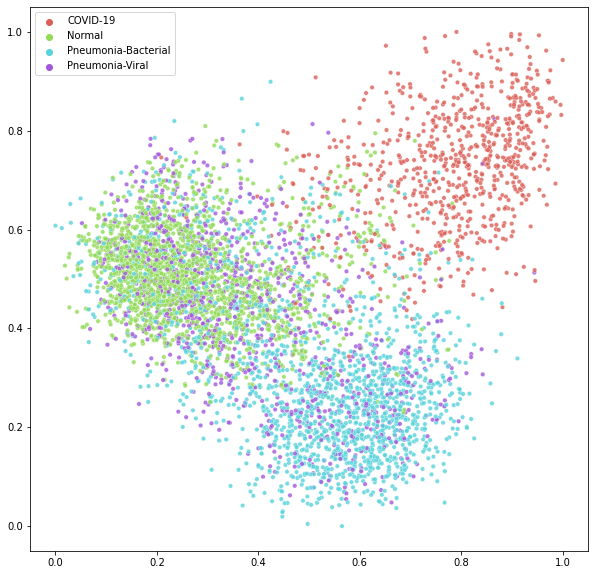

In [ ]:
plt.figure(figsize=(10, 10))
sns.scatterplot(
    x=normalized_pca[:,0], 
    y=normalized_pca[:,1],
    hue=np.vectorize(label_to_type.get)(labels),
    palette=sns.color_palette("hls", 4),
    legend="full",
    alpha=0.8, 
    s=20, 
    hue_order=classes
)

###Conclusion: With tSNE, samples are better spaced apart and grouped together with their respective classes.